# Introduction

**Name**: Daniel Ponda.  
**Class/Batch/Phase**: FTDS/001/02.

# Dataset Description

Dataset yang digunakan adalah macam-macam gambar batu, gunting, dan kertas.

Source: https://www.kaggle.com/sanikamal/rock-paper-scissors-dataset

# Objective

Tujuan dari project ini adalah untuk membedakan gambar batu, gunting, dan kertas dalam permainan batu,gunting,kertas.

# Import Library

In [1]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.datasets import load_sample_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import matplotlib.pyplot as plt

# Data Loading

In [2]:
# Definisikan path dataset
train_folder=r'Rock-Paper-Scissors/train'
val_folder=r'Rock-Paper-Scissors/test'

# EDA

In [3]:
import pathlib
data_train = pathlib.Path(train_folder)
data_val = pathlib.Path(val_folder)
Rock_train = len(list(data_train.glob('rock/*')))
Scissors_train = len(list(data_train.glob('scissors/*')))
Paper_train = len(list(data_train.glob('paper/*')))
Rock_val = len(list(data_val.glob('rock/*')))
Scissors_val = len(list(data_val.glob('scissors/*')))
Paper_val = len(list(data_val.glob('paper/*')))
train_data = len(list(data_train.glob('*/*.png')))
val_data = len(list(data_val.glob('*/*.png')))

In [4]:
print('Total training Paper images:', Paper_train)
print('Total training Scissors images:', Scissors_train)
print('Total training Rock images:', Rock_train)
print("-"*50)
print('Total validation Paper images:', Paper_val)
print('Total validation Scissors images:', Scissors_val)
print('Total validation Rock images:', Rock_val)
print("-"*50)
print("Total training images:", train_data)
print("Total validation images:", val_data)

Total training Paper images: 840
Total training Scissors images: 840
Total training Rock images: 840
--------------------------------------------------
Total validation Paper images: 124
Total validation Scissors images: 124
Total validation Rock images: 124
--------------------------------------------------
Total training images: 2520
Total validation images: 372


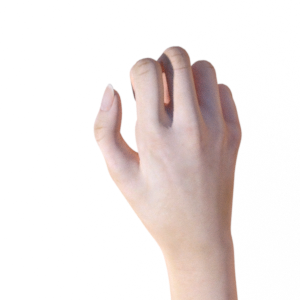

In [5]:
rock = list(data_train.glob('rock/*'))
PIL.Image.open(str(rock[0]))

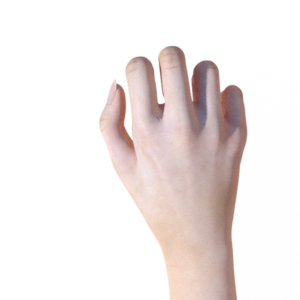

In [6]:
PIL.Image.open(str(rock[5]))

In [7]:
Scissors = list(data_train.glob('scissors/*'))
PIL.Image.open(str(Scissors[0]))
Scissors_data=len(Scissors)
print(Scissors_data)

840


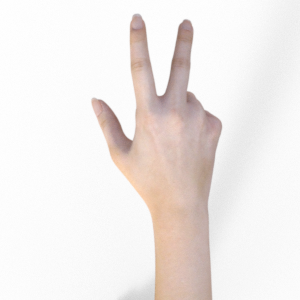

In [8]:
PIL.Image.open(str(Scissors[12]))

In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_folder)

Found 2520 files belonging to 3 classes.


In [10]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


ukuran gambar original adalah 256x256

# Setting the model parameters

In [11]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 4

# Preprocessing

In [12]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 2520 files belonging to 3 classes.


In [13]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size)

Found 372 files belonging to 3 classes.


In [14]:
class_names = train_dataset.class_names
print(class_names)

['paper', 'rock', 'scissors']


In [15]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 150, 150, 3)
(4,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./225)

In [18]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.19444445 1.1311111


# Modeling

## Create Model

In [19]:
# Model without data_augmentation
num_classes = 3
model = Sequential([
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])

Data augmentation for second model

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [21]:
# Model with data_augmentation, and regularizer(mencegah overfitting)
num_classes = 3
model1 = Sequential([
    data_augmentation,
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    # Menambah bias regularizer agar normal
    layers.Conv2D(128, (3,3), padding='same', activation='relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)),
    layers.MaxPooling2D(2,2),
    
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])

## Compile Model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [24]:
# Train model yang tidak menggunakan data augmentation
epochs = 10
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 37s 58ms/step - loss: 3.6660 - accuracy: 0.8504 - val_loss: 0.9243 - val_accuracy: 0.7742
Epoch 2/10
630/630 [==============================] - 35s 55ms/step - loss: 0.1701 - accuracy: 0.9532 - val_loss: 1.2595 - val_accuracy: 0.7634
Epoch 3/10
630/630 [==============================] - 35s 55ms/step - loss: 0.2302 - accuracy: 0.9639 - val_loss: 0.4416 - val_accuracy: 0.8737
Epoch 4/10
630/630 [==============================] - 35s 56ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 1.2646 - val_accuracy: 0.8522
Epoch 5/10
630/630 [==============================] - 36s 56ms/step - loss: 1.1241e-04 - accuracy: 1.0000 - val_loss: 1.3763 - val_accuracy: 0.8414
Epoch 6/10
630/630 [==============================] - 36s 57ms/step - loss: 2.6061e-06 - accuracy: 1.0000 - val_loss: 1.3196 - val_accuracy: 0.8575
Epoch 7/10
630/630 [==============================] - 36s 57ms/step - loss: 5.0475e-07 - accuracy: 1.0000 - val_loss: 1.3244 - v

In [25]:
# Train model yang menggunakan data augmentation
epochs = 10
history1 = model1.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 42s 66ms/step - loss: 3.3287 - accuracy: 0.6321 - val_loss: 0.5419 - val_accuracy: 0.8011
Epoch 2/10
630/630 [==============================] - 44s 70ms/step - loss: 0.6102 - accuracy: 0.7587 - val_loss: 0.2618 - val_accuracy: 0.8898
Epoch 3/10
630/630 [==============================] - 42s 66ms/step - loss: 0.3177 - accuracy: 0.8817 - val_loss: 0.3718 - val_accuracy: 0.8387
Epoch 4/10
630/630 [==============================] - 40s 64ms/step - loss: 0.2471 - accuracy: 0.9067 - val_loss: 0.2444 - val_accuracy: 0.8817
Epoch 5/10
630/630 [==============================] - 41s 65ms/step - loss: 0.2461 - accuracy: 0.9258 - val_loss: 0.1599 - val_accuracy: 0.9355
Epoch 6/10
630/630 [==============================] - 43s 67ms/step - loss: 0.1670 - accuracy: 0.9401 - val_loss: 0.4929 - val_accuracy: 0.8441
Epoch 7/10
630/630 [==============================] - 42s 66ms/step - loss: 0.1465 - accuracy: 0.9540 - val_loss: 0.2403 - val_accuracy:

# Model Evaluate

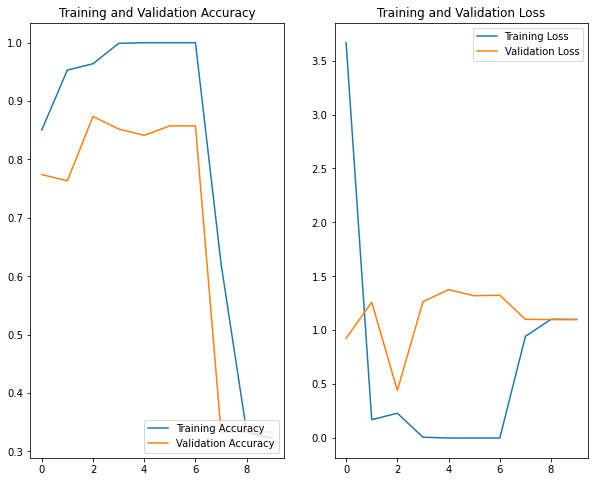

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

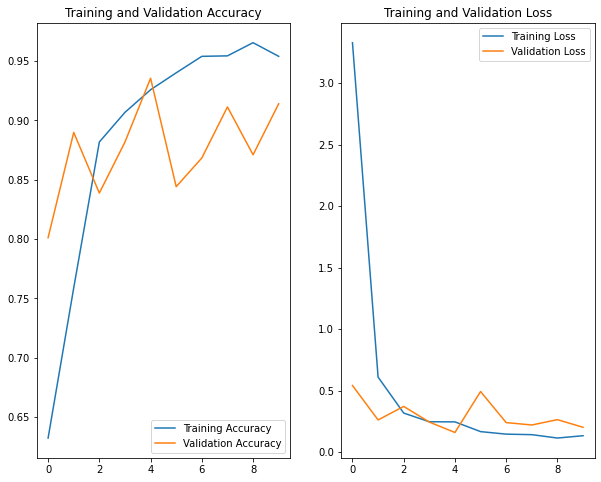

In [27]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
test_evaluate = model.evaluate(val_dataset)

93/93 [==============================] - 1s 13ms/step - loss: 1.0986 - accuracy: 0.3333


In [29]:
test_evaluate1 = model1.evaluate(val_dataset)

93/93 [==============================] - 1s 13ms/step - loss: 0.2021 - accuracy: 0.9140


# Model Inference

In [30]:
test_path = r'Rock-Paper-Scissors/newdata'
test_data = pathlib.Path(test_path)
test_img =list(test_data.glob('*'))

In [31]:
test_img

[WindowsPath('Rock-Paper-Scissors/newdata/batu.png'),
 WindowsPath('Rock-Paper-Scissors/newdata/gunting.png'),
 WindowsPath('Rock-Paper-Scissors/newdata/kertas.png')]

In [32]:
class_names

['paper', 'rock', 'scissors']

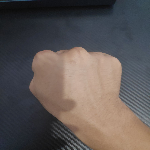

With model 1 this image most likely belongs to scissors with a 33.66 percent confidence.
With model 2 this image most likely belongs to rock with a 99.65 percent confidence.
----------------------------------------------------------------------------------------------------


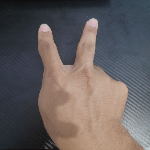

With model 1 this image most likely belongs to scissors with a 33.66 percent confidence.
With model 2 this image most likely belongs to scissors with a 79.68 percent confidence.
----------------------------------------------------------------------------------------------------


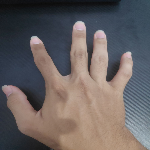

With model 1 this image most likely belongs to scissors with a 33.66 percent confidence.
With model 2 this image most likely belongs to paper with a 70.25 percent confidence.
----------------------------------------------------------------------------------------------------


In [33]:
for i in range (len(test_img)):
    img = keras.preprocessing.image.load_img(test_img[i], target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predictions1 = model1.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    score1 = tf.nn.softmax(predictions1[0])
    display(img)
    print(
        "With model 1 this image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(
        "With model 2 this image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score1)], 100 * np.max(score1)))
    print("-"*100)

# EDA Analysis

1. Ada 2520 image pada data Train 
2. Ada 372 image pada data Validation
3. Pada Data Train, setiap lebel memiliki masing-masing 840 image
4. Pada Data Validation , setiap lebel memiliki masing-masing 124 image

# Model Analysis

Model tanpa menggunakan data augmentation, training loss dan validation loss memiliki perbedaan yang jauh

Model yang menggunakan data augmentation lebih stabil. karna data untuk train dan validation balance